In [1]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras import utils as np_utils

from random import shuffle
from tensorflow.python.client import device_lib

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For wider plots
plt.rcParams["figure.figsize"] = (20,6)

os.environ['TF_XLA_FLAGS']="--tf_xla_enable_xla_devices"
# Take my NVidia GPU into use
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"

2023-04-30 19:16:36.621008: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-th_j1egg because the default path (/home/harsh/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
from tensorflow.python.client import device_lib 
os.environ['TF_XLA_FLAGS']="--tf_xla_enable_xla_devices"
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14400963599568954059
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7154340530738083145
physical_device_desc: "device: XLA_CPU device"
]


2023-04-30 19:16:39.063998: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 19:16:39.100380: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz
2023-04-30 19:16:39.104511: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xefbf60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-04-30 19:16:39.104558: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-04-30 19:16:39.110738: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-30 19:16:39.177168: E tensorflow/stream_executor/cu

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [4]:
files1 = glob.glob("./parkinsons/*Ga**Co*.txt")
files2 = glob.glob("./parkinsons/*Ga**Pt*.txt")
files1j = glob.glob("./parkinsons/*Ju**Co*.txt")
files2j = glob.glob("./parkinsons/*Ju**Pt*.txt")
files1s = glob.glob("./parkinsons/*Si**Co*.txt")
files2s = glob.glob("./parkinsons/*Si**Pt*.txt")
# files=files1+files2
# shuffle(files)

In [5]:
print(len(files1))
print(len(files2))     
print(len(files1j))
print(len(files2j))     
print(len(files1s))
print(len(files2s))     

38
75
25
104
29
35


In [6]:
columns = ["elaps_time","L1", "L2","L3","L4","L5","L6","L7","L8","R1","R2","R3","R4","R5","R6","R7","R8","LTot","RTot"]

In [7]:
def getClassForHealthyOrNot(filename):
    if (filename.find("Co") >=0):
        return 0
    else:
        return 1


In [8]:
class Patient:
    def __init__(self,input_data,y):
        self.x = input_data
        self.y = y
        self.x_scaled = input_data

In [9]:
patients=[]
un_used_data=[]

for f in files1:
    #print(f"{i+1}. {file}")
    
    data_txt = pd.read_table(f,names=columns)
    data_txt.drop(['elaps_time'],inplace=True,axis=1)
    
    
    
    j=0
    ispark = getClassForHealthyOrNot(f)
    # print(ispark)
    while j < 12001:
        data = data_txt.iloc[j+1:j+151,:]
        
        if data.shape[0] == 150:
            patients.append( Patient(data, ispark) )
        
        j=j+75

In [10]:
patients1=[]
un_used_data1=[]

for f in files2:
    #print(f"{i+1}. {file}")
    
    data_txt = pd.read_table(f,names=columns)
    data_txt.drop(['elaps_time'],inplace=True,axis=1)
    
    
    
    j=0
    ispark = getClassForHealthyOrNot(f)
    # print(ispark)
    while j < 12001:
        data = data_txt.iloc[j+1:j+151,:]
        
        if data.shape[0] == 150:
            patients1.append( Patient(data, ispark) )
        
        j=j+75

In [11]:
len(patients)

5972

In [12]:
len(patients1)


12000

In [13]:
shuffle(patients)
shuffle(patients1)

In [14]:
train = patients[:int(len(patients)*0.8)]+patients1[:int(len(patients1)*0.8)]
test = patients[int(len(patients)*0.8):]+patients1[int(len(patients1)*0.8):]

In [15]:
print(len(train))
print(len(test))

14377
3595


In [16]:
shuffle(train)
shuffle(test)

In [17]:
train_concat=[]
for p in train:
    train_concat = train_concat+[p.x]

In [18]:
data_tr = pd.concat(train_concat,ignore_index=True)

In [19]:
scaler = StandardScaler()
scaler.fit_transform(data_tr)

array([[ 0.55637509,  0.32127161,  0.29253343, ..., -0.76741576,
         1.39435066, -1.1257737 ],
       [ 0.43423612,  0.2259723 ,  0.17253494, ..., -0.76741576,
         1.39435066, -1.1257737 ],
       [ 0.30446347,  0.13197846,  0.05698084, ..., -0.76741576,
         1.36647677, -1.09741081],
       ...,
       [-0.63666088, -0.6800239 , -0.65856569, ...,  0.00223702,
        -1.12620704,  1.08625899],
       [-0.63666088, -0.6800239 , -0.65856569, ...,  0.00223702,
        -1.12620704,  1.0008976 ],
       [-0.63666088, -0.6800239 , -0.65856569, ...,  0.04193258,
        -1.12620704,  0.9384447 ]])

In [20]:
i=0
wo_time_col=["L1", "L2","L3","L4","L5","L6","L7","L8","R1","R2","R3","R4","R5","R6","R7","R8","LTot","RTot"]
for obj in train:
    obj.x_scaled = pd.DataFrame(scaler.transform(obj.x),columns=wo_time_col)
    i=i+1

In [21]:
for obj in test:
    obj.x_scaled = pd.DataFrame(scaler.transform(obj.x),columns=wo_time_col)
    i=i+1

In [22]:
X_scaled_list_train=[]
Y_list_train=[]

for obj in train:
    X_scaled_list_train = X_scaled_list_train + [obj.x_scaled]
    Y_list_train = Y_list_train + [obj.y]
    
X_scaled_arr_train = np.array(X_scaled_list_train)
Y_arr_train = np.array(Y_list_train)

In [23]:
X_scaled_arr_train.shape

(14377, 150, 18)

In [24]:
Y_arr_train.shape

(14377,)

In [25]:
X_scaled_list_test=[]
Y_list_test=[]

for obj in test:
    X_scaled_list_test = X_scaled_list_test + [obj.x_scaled]
    Y_list_test = Y_list_test + [obj.y]
    
X_scaled_arr_test = np.array(X_scaled_list_test)
Y_arr_test = np.array(Y_list_test)

In [26]:
import numpy as np

In [27]:
model = Sequential()
model.add(Bidirectional(LSTM(80, dropout=0.3, 
                  return_sequences=True, 
                  input_shape=(X_scaled_arr_train.shape[1], X_scaled_arr_train.shape[2]))))
model.add(Bidirectional(LSTM(32, dropout=0.5,return_sequences=True)))
model.add(LSTM(24, dropout=0.2,return_sequences=True))
model.add(LSTM(12, dropout=0.2,return_sequences=False))
model.add(Dense(1, kernel_initializer='glorot_uniform', activation='relu'))
opt=tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    name="Adam"
    )
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10|0, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("./Model/model_LSTM22_150_cross_test.v", 
                             monitor='val_accuracy', verbose=1, save_best_only=True, 
                             save_weights_only=False)

In [28]:
history = model.fit(X_scaled_arr_train,Y_arr_train,epochs=500,validation_split=0.2,batch_size=20,shuffle=True,callbacks=[early_stopping, checkpoint])

2023-04-30 19:17:32.817546: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/500
576/576 [==============================] - 283s 478ms/step - loss: 1.3693 - accuracy: 0.4962 - val_loss: 0.5682 - val_accuracy: 0.7045

Epoch 00001: val_accuracy improved from -inf to 0.70445, saving model to ./Model/model_LSTM22_150_cross_test.v


2023-04-30 19:22:24.711484: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 2/500
576/576 [==============================] - 246s 426ms/step - loss: 0.5661 - accuracy: 0.7120 - val_loss: 0.4757 - val_accuracy: 0.7747

Epoch 00002: val_accuracy improved from 0.70445 to 0.77469, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 3/500
576/576 [==============================] - 242s 421ms/step - loss: 0.4833 - accuracy: 0.7868 - val_loss: 0.4554 - val_accuracy: 0.7837

Epoch 00003: val_accuracy improved from 0.77469 to 0.78373, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 4/500
576/576 [==============================] - 242s 420ms/step - loss: 0.4329 - accuracy: 0.8149 - val_loss: 0.3357 - val_accuracy: 0.8964

Epoch 00004: val_accuracy improved from 0.78373 to 0.89638, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 5/500
576/576 [==============================] - 241s 418ms/step - loss: 0.3338 - accuracy: 0.8783 - val_loss: 0.2814 - val_accuracy: 0.9398

Epoch 00005: val_accuracy improved from 0.89638 to 0.93985, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 6/500
576/576 [==============================] - 241s 419ms/step - loss: 0.2674 - accuracy: 0.9160 - val_loss: 0.2994 - val_accuracy: 0.9336

Epoch 00006: val_accuracy did not improve from 0.93985
Epoch 7/500
576/576 [==============================] - 239s 416ms/step - loss: 0.2688 - accuracy: 0.9250 - val_loss: 0.1844 - val_accuracy: 0.9611

Epoch 00007: val_accuracy improved from 0.93985 to 0.96106, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 8/500
576/576 [==============================] - 239s 414ms/step - loss: 0.2153 - accuracy: 0.9483 - val_loss: 0.7256 - val_accuracy: 0.6937

Epoch 00008: val_accuracy did not improve from 0.96106
Epoch 9/500
576/576 [==============================] - 236s 410ms/step - loss: 0.6336 - accuracy: 0.7016 - val_loss: 0.5295 - val_accuracy: 0.7483

Epoch 00009: val_accuracy did not improve from 0.96106
Epoch 10/500
576/576 [==============================] - 236s 410ms/step - loss: 0.5321 - accuracy: 0.7527 - val_loss: 0.4247 - val_accuracy: 0.8143

Epoch 00010: val_accuracy did not improve from 0.96106
Epoch 11/500
576/576 [==============================] - 237s 411ms/step - loss: 0.4444 - accuracy: 0.8023 - val_loss: 0.2919 - val_accuracy: 0.8745

Epoch 00011: val_accuracy did not improve from 0.96106
Epoch 12/500
576/576 [==============================] - 236s 410ms/step - loss: 0.3908 - accuracy: 0.8526 - val_loss: 0.3894 - val_accuracy: 0.8661

Epoch 00012: val_accuracy did not imp

INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 17/500
576/576 [==============================] - 230s 399ms/step - loss: 0.1995 - accuracy: 0.9523 - val_loss: 0.1218 - val_accuracy: 0.9732

Epoch 00017: val_accuracy improved from 0.97253 to 0.97323, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 18/500
576/576 [==============================] - 231s 400ms/step - loss: 0.1650 - accuracy: 0.9607 - val_loss: 0.1036 - val_accuracy: 0.9774

Epoch 00018: val_accuracy improved from 0.97323 to 0.97740, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 19/500
576/576 [==============================] - 227s 394ms/step - loss: 0.1695 - accuracy: 0.9622 - val_loss: 0.1866 - val_accuracy: 0.9656

Epoch 00019: val_accuracy did not improve from 0.97740
Epoch 20/500
576/576 [==============================] - 228s 396ms/step - loss: 0.1671 - accuracy: 0.9625 - val_loss: 0.1162 - val_accuracy: 0.9816

Epoch 00020: val_accuracy improved from 0.97740 to 0.98157, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 21/500
576/576 [==============================] - 227s 393ms/step - loss: 0.1131 - accuracy: 0.9736 - val_loss: 0.3361 - val_accuracy: 0.8766

Epoch 00021: val_accuracy did not improve from 0.98157
Epoch 22/500
576/576 [==============================] - 225s 391ms/step - loss: 0.2908 - accuracy: 0.8986 - val_loss: 0.1859 - val_accuracy: 0.9590

Epoch 00022: val_accuracy did not improve from 0.98157
Epoch 23/500
576/576 [==============================] - 225s 391ms/step - loss: 0.1683 - accuracy: 0.9517 - val_loss: 0.1228 - val_accuracy: 0.9788

Epoch 00023: val_accuracy did not improve from 0.98157
Epoch 24/500
576/576 [==============================] - 223s 387ms/step - loss: 0.2516 - accuracy: 0.9516 - val_loss: 0.1178 - val_accuracy: 0.9819

Epoch 00024: val_accuracy improved from 0.98157 to 0.98192, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 25/500
576/576 [==============================] - 222s 386ms/step - loss: 0.1304 - accuracy: 0.9735 - val_loss: 0.0994 - val_accuracy: 0.9805

Epoch 00025: val_accuracy did not improve from 0.98192
Epoch 26/500
576/576 [==============================] - 223s 388ms/step - loss: 0.1060 - accuracy: 0.9740 - val_loss: 0.0733 - val_accuracy: 0.9830

Epoch 00026: val_accuracy improved from 0.98192 to 0.98296, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 27/500
576/576 [==============================] - 224s 388ms/step - loss: 0.0870 - accuracy: 0.9806 - val_loss: 0.0990 - val_accuracy: 0.9885

Epoch 00027: val_accuracy improved from 0.98296 to 0.98853, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 28/500
576/576 [==============================] - 223s 388ms/step - loss: 0.0899 - accuracy: 0.9824 - val_loss: 0.1001 - val_accuracy: 0.9854

Epoch 00028: val_accuracy did not improve from 0.98853
Epoch 29/500
576/576 [==============================] - 223s 387ms/step - loss: 0.1054 - accuracy: 0.9774 - val_loss: 0.0614 - val_accuracy: 0.9906

Epoch 00029: val_accuracy improved from 0.98853 to 0.99061, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 30/500
576/576 [==============================] - 222s 386ms/step - loss: 0.1148 - accuracy: 0.9805 - val_loss: 0.1326 - val_accuracy: 0.9812

Epoch 00030: val_accuracy did not improve from 0.99061
Epoch 31/500
576/576 [==============================] - 223s 387ms/step - loss: 0.2749 - accuracy: 0.9550 - val_loss: 0.0571 - val_accuracy: 0.9910

Epoch 00031: val_accuracy improved from 0.99061 to 0.99096, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 32/500
576/576 [==============================] - 220s 382ms/step - loss: 0.1469 - accuracy: 0.9720 - val_loss: 0.0651 - val_accuracy: 0.9885

Epoch 00032: val_accuracy did not improve from 0.99096
Epoch 33/500
576/576 [==============================] - 223s 387ms/step - loss: 0.0788 - accuracy: 0.9853 - val_loss: 0.0399 - val_accuracy: 0.9917

Epoch 00033: val_accuracy improved from 0.99096 to 0.99166, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 34/500
576/576 [==============================] - 224s 388ms/step - loss: 0.1247 - accuracy: 0.9749 - val_loss: 0.0628 - val_accuracy: 0.9864

Epoch 00034: val_accuracy did not improve from 0.99166
Epoch 35/500
576/576 [==============================] - 224s 389ms/step - loss: 0.0715 - accuracy: 0.9820 - val_loss: 0.0474 - val_accuracy: 0.9906

Epoch 00035: val_accuracy did not improve from 0.99166
Epoch 36/500
576/576 [==============================] - 223s 387ms/step - loss: 0.0680 - accuracy: 0.9848 - val_loss: 0.0452 - val_accuracy: 0.9927

Epoch 00036: val_accuracy improved from 0.99166 to 0.99270, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 37/500
576/576 [==============================] - 223s 387ms/step - loss: 0.0885 - accuracy: 0.9852 - val_loss: 0.0337 - val_accuracy: 0.9944

Epoch 00037: val_accuracy improved from 0.99270 to 0.99444, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 38/500
576/576 [==============================] - 222s 386ms/step - loss: 0.0781 - accuracy: 0.9872 - val_loss: 0.0625 - val_accuracy: 0.9868

Epoch 00038: val_accuracy did not improve from 0.99444
Epoch 39/500
576/576 [==============================] - 223s 387ms/step - loss: 0.0994 - accuracy: 0.9782 - val_loss: 0.0827 - val_accuracy: 0.9826

Epoch 00039: val_accuracy did not improve from 0.99444
Epoch 40/500
576/576 [==============================] - 223s 387ms/step - loss: 0.0718 - accuracy: 0.9813 - val_loss: 0.0505 - val_accuracy: 0.9937

Epoch 00040: val_accuracy did not improve from 0.99444
Epoch 41/500
576/576 [==============================] - 221s 384ms/step - loss: 0.0401 - accuracy: 0.9904 - val_loss: 0.0392 - val_accuracy: 0.9944

Epoch 00041: val_accuracy did not improve from 0.99444
Epoch 42/500
576/576 [==============================] - 223s 387ms/step - loss: 0.0491 - accuracy: 0.9897 - val_loss: 0.0333 - val_accuracy: 0.9934

Epoch 00042: val_accuracy did not i

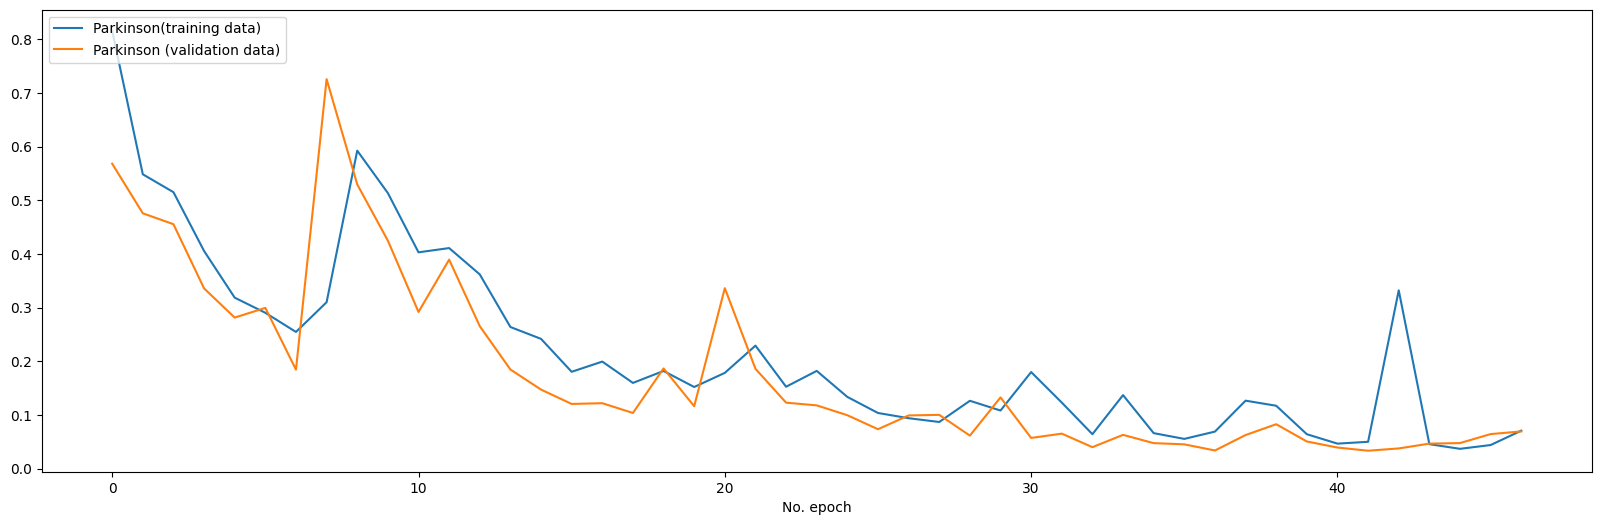

In [29]:
plt.plot(history.history['loss'], label='Parkinson(training data)')
plt.plot(history.history['val_loss'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

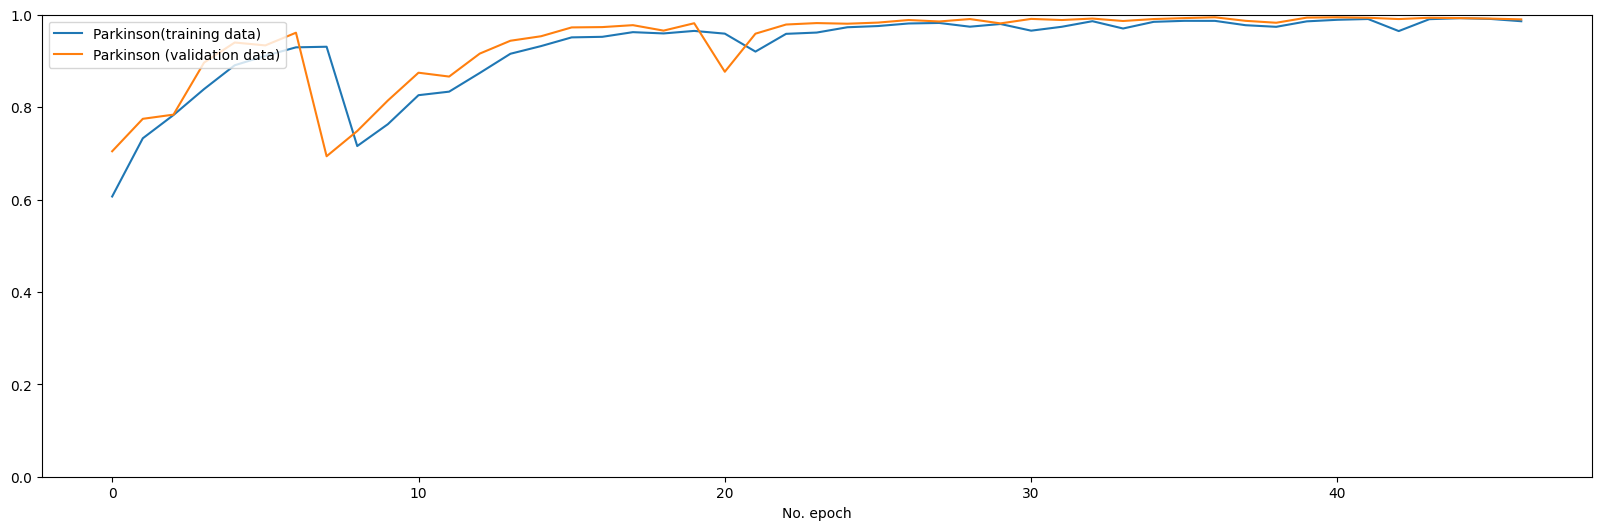

In [30]:
plt.plot(history.history['accuracy'], label='Parkinson(training data)')
plt.plot(history.history['val_accuracy'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.ylim(0,1)
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

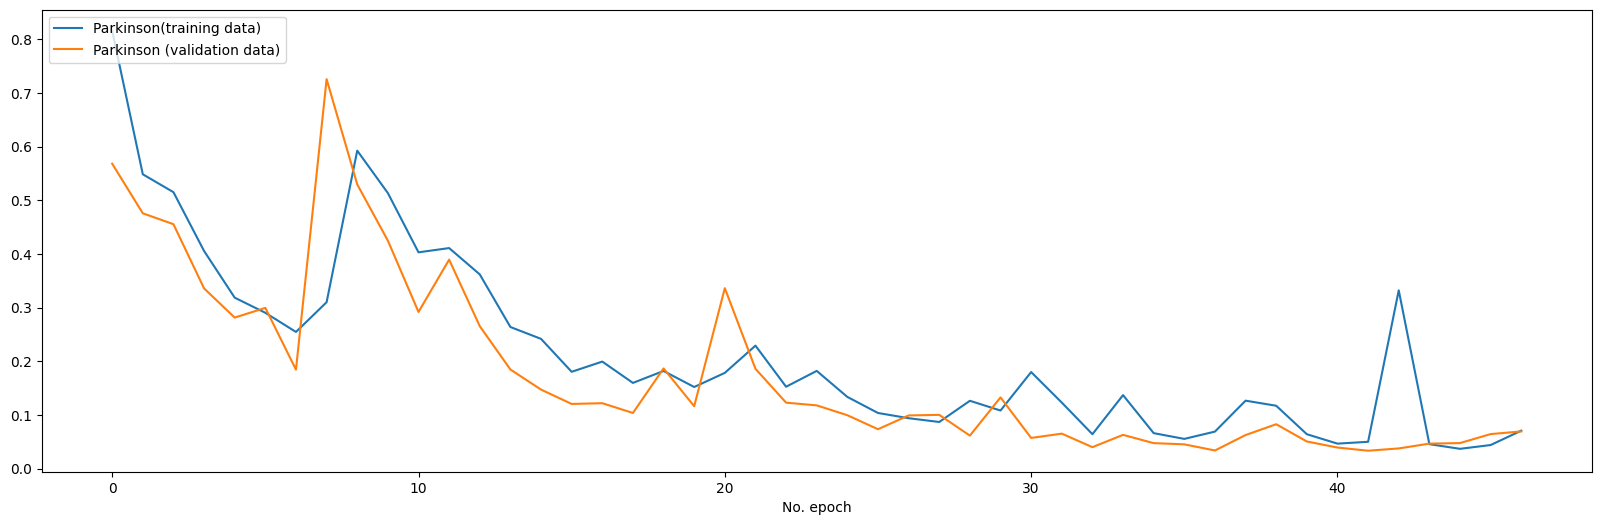

In [31]:
plt.plot(history.history['loss'], label='Parkinson(training data)')
plt.plot(history.history['val_loss'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [32]:
pdt1=model.predict(X_scaled_arr_test)
pdt1.size
classes_x1 = np.zeros((len(pdt1)))
for x in range(len(pdt1)):
  if(pdt1[x]>0.5):
    classes_x1[x]=(1)
  else:
    classes_x1[x]=(0)
#   print(x,end=" ")
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_arr_test,classes_x1 )

In [33]:
accuracy

0.9899860917941585

In [42]:
patients_t=[]
un_used_data_t=[]

for f in files1j:
    #print(f"{i+1}. {file}")
    
    data_txt = pd.read_table(f,names=columns)
    data_txt.drop(['elaps_time'],inplace=True,axis=1)
    
    
    
    j=0
    ispark = getClassForHealthyOrNot(f)
    # print(ispark)
    while j < 12001:
        data = data_txt.iloc[j+1:j+151,:]
        
        if data.shape[0] == 150:
            patients_t.append( Patient(data, ispark) )
        
        j=j+75

In [43]:
patients1_t=[]
un_used_data1_t=[]

for f in files2j:
    #print(f"{i+1}. {file}")
    
    data_txt = pd.read_table(f,names=columns)
    data_txt.drop(['elaps_time'],inplace=True,axis=1)
    
    
    
    j=0
    ispark = getClassForHealthyOrNot(f)
    # print(ispark)
    while j < 12001:
        data = data_txt.iloc[j+1:j+151,:]
        
        if data.shape[0] == 150:
            patients1_t.append( Patient(data, ispark) )
        
        j=j+75

In [44]:
len(patients_t)

2749

In [45]:
test_t= patients+patients1_t

In [46]:
wo_time_col=["L1", "L2","L3","L4","L5","L6","L7","L8","R1","R2","R3","R4","R5","R6","R7","R8","LTot","RTot"]
for obj in test_t:
    obj.x_scaled = pd.DataFrame(scaler.transform(obj.x),columns=wo_time_col)
    i=i+1
    
X_scaled_list_test_t=[]
Y_list_test_t=[]

for obj in test_t:
    X_scaled_list_test_t = X_scaled_list_test_t + [obj.x_scaled]
    Y_list_test_t = Y_list_test_t + [obj.y]
    
X_scaled_arr_test_t = np.array(X_scaled_list_test_t)
Y_arr_test_t = np.array(Y_list_test_t)

In [47]:
pdt1_t=model.predict(X_scaled_arr_test_t)
pdt1_t.size
classes_x1_t = np.zeros((len(pdt1_t)))
for x in range(len(pdt1_t)):
  if(pdt1_t[x]>0.5):
    classes_x1_t[x]=(1)
  else:
    classes_x1_t[x]=(0)
#   print(x,end=" ")
from sklearn.metrics import accuracy_score
accuracy_t = accuracy_score(Y_arr_test_t,classes_x1_t )

In [40]:
accuracy_t

0.8398721050812306

In [48]:
accuracy_t

0.8055001108893325